In [10]:
import numpy as np
import os

import matplotlib.pyplot as plt

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [11]:
## Get a webpage and store in a local file, make the local file get the name of the
##  remote document (if no filename part is specified in the URL, this fails):
!curl -O https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
!curl -O https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  15.6M      0  0:00:48  0:00:48 --:--:-- 15.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  5135k      0  0:00:03  0:00:03 --:--:-- 5135k


In [12]:
input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (128, 128)
num_classes = 3 # the three pixels in the trimap mask
batch_size = 32

In [13]:
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


In [14]:
import keras
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io

def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        target_img -= 1
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

In [15]:
import random
seed = 42
# Split our img paths into a train and a test sets
test_samples = 1000
train_samples = 1000
random.Random(seed).shuffle(input_img_paths)
random.Random(seed).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:train_samples]
train_target_img_paths = target_img_paths[:train_samples]
val_input_img_paths = input_img_paths[train_samples:(len(input_img_paths)-test_samples)]
val_target_img_paths = target_img_paths[train_samples:(len(input_img_paths)-test_samples)]
test_input_img_paths = input_img_paths[(len(input_img_paths)-test_samples):]
test_target_img_paths = target_img_paths[(len(input_img_paths)-test_samples):]
print(f"number of validation samples:{len(val_input_img_paths)}")
print(f"number of test samples:{len(test_input_img_paths)}")
print(f"number of train samples:{len(train_input_img_paths)}")

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
  # max_dataset_len=1000,
)
val_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)
test_dataset = get_dataset(
    batch_size, img_size, test_input_img_paths, test_target_img_paths
)

number of validation samples:5390
number of test samples:1000
number of train samples:1000


In [16]:
from keras.models import Model, load_model
from keras.layers import Input, Lambda, Dropout, Conv2D, Conv2DTranspose, Reshape
from keras.layers import MaxPooling2D, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [32]:

filters = [8, 12, 16, 20, 24]
i = 0
## add a third dimension of value 3. We have RGB images
inputs = Input(shape=img_size + (3,))
#s = Rescaling(1./255)(inputs),
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)
i+=1
c2 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)
i += 1
c3 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)
i += 1
c4 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
i += 1
c5 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (c5)
i -= 1
### HERE ENDS ENCODER
u6 = Conv2DTranspose(filters[i], (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (c6)
i -= 1
u7 = Conv2DTranspose(filters[i], (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (c7)
i -= 1
u8 = Conv2DTranspose(filters[i], (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (c8)
i -= 1
u9 = Conv2DTranspose(filters[i], (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (c9)

# Add a per-pixel classification layer
outputs = Conv2D(3, (1, 1), activation="softmax")(c9)

model = Model(inputs=[inputs], outputs=[outputs])
lr = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='sparse_categorical_crossentropy')

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda_10 (Lambda)          (None, 128, 128, 3)          0         ['input_7[0][0]']             
                                                                                                  
 conv2d_114 (Conv2D)         (None, 128, 128, 8)          224       ['lambda_10[0][0]']           
                                                                                                  
 dropout_54 (Dropout)        (None, 128, 128, 8)          0         ['conv2d_114[0][0]']          
                                                                                            

In [33]:
filepath = "model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0,
                             save_best_only=True, mode='min')

callbacks_list = [checkpoint, earlystopper]

epochs = 40
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks_list,
    verbose=2,
)

Epoch 1/40
32/32 - 25s - loss: 0.9743 - val_loss: 0.8420 - 25s/epoch - 779ms/step
Epoch 2/40
32/32 - 17s - loss: 0.8055 - val_loss: 0.7739 - 17s/epoch - 519ms/step
Epoch 3/40
32/32 - 17s - loss: 0.7537 - val_loss: 0.7863 - 17s/epoch - 519ms/step
Epoch 4/40
32/32 - 19s - loss: 0.7425 - val_loss: 0.7299 - 19s/epoch - 609ms/step
Epoch 5/40
32/32 - 17s - loss: 0.7210 - val_loss: 0.7392 - 17s/epoch - 519ms/step
Epoch 6/40
32/32 - 17s - loss: 0.7157 - val_loss: 0.7156 - 17s/epoch - 517ms/step
Epoch 7/40
32/32 - 17s - loss: 0.7006 - val_loss: 0.7090 - 17s/epoch - 517ms/step
Epoch 8/40
32/32 - 17s - loss: 0.6905 - val_loss: 0.6905 - 17s/epoch - 523ms/step
Epoch 9/40
32/32 - 17s - loss: 0.6699 - val_loss: 0.6618 - 17s/epoch - 520ms/step
Epoch 10/40
32/32 - 17s - loss: 0.6538 - val_loss: 0.6444 - 17s/epoch - 522ms/step
Epoch 11/40
32/32 - 18s - loss: 0.6394 - val_loss: 0.6254 - 18s/epoch - 563ms/step
Epoch 12/40
32/32 - 17s - loss: 0.6259 - val_loss: 0.6081 - 17s/epoch - 542ms/step
Epoch 13/40
3

In [36]:
predictions = model.predict(test_dataset)

integer_predictions = np.argmax(predictions, axis = -1)

32/32 [==============================] - 5s 138ms/step


In [37]:
from IPython.display import Image, display
from PIL import Image as Im
from keras.utils import load_img
from PIL import ImageOps

----- test image: 0
	 imput image: 0


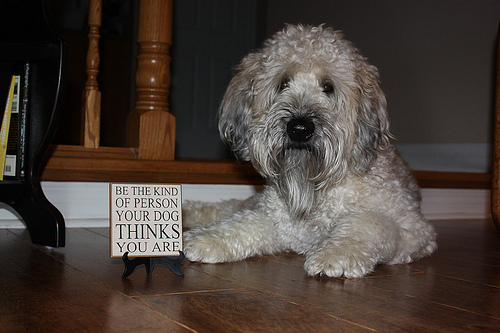

	 ground truth mask image: 0


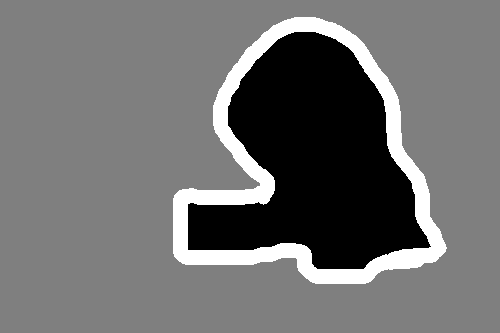

	 predicted mask image: 0


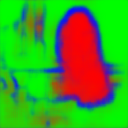

----- test image: 1
	 imput image: 1


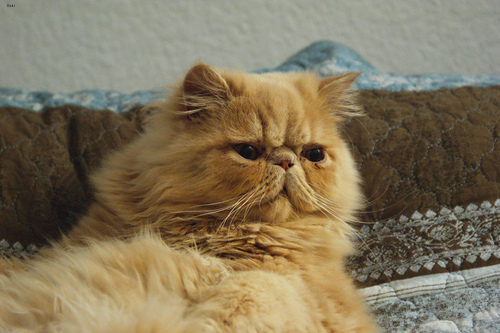

	 ground truth mask image: 1


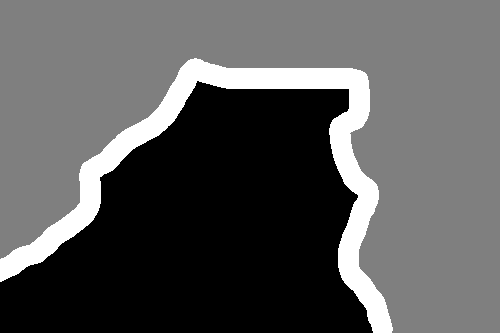

	 predicted mask image: 1


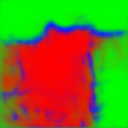

In [39]:
nimg = 2
for i in range(nimg):
  print(f"----- test image: {i}")
  print(f"\t imput image: {i}")
  # Display input image
  display(Image(filename=test_input_img_paths[i]))

  print(f"\t ground truth mask image: {i}")
  # Display ground-truth target mask
  img = ImageOps.autocontrast(load_img(test_target_img_paths[i]))
  display(img)


  print(f"\t predicted mask image: {i}")
  # Display mask predicted by our model
  img = ImageOps.autocontrast(tf.keras.utils.array_to_img(predictions[i]))
  # Note that the model only sees inputs at 128x128.
  display(img)
